# EDA (Exploratory Data Analysis) of the dataset

In this notebook, explore the Abalone dataset, by showing relevant visualizations that help understand the problem you are modelling.

Please make sure to write down your conclusions in the final notebook and to remove these intructions.

# Imports

In [1]:
# Autoreload settings
%load_ext autoreload
%autoreload 2

# Pandas and display settings
import pandas as pd

pd.set_option("display.max_columns", 500)

# General imports
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Data profiling
from ydata_profiling import ProfileReport

# Plotly for interactive plots
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Machine learning imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Ensure inline plotting in Jupyter-style environments
%matplotlib inline

# Data

In [2]:
DATA_FOLDER = "../data"
dataset_path = f"{DATA_FOLDER}/abalone.csv"

df = pd.read_csv(dataset_path)

# EDA

In [3]:
df.head()

Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [5]:
# Generate a profile report for the dataset
profile = ProfileReport(df, title="First look at the given dataset")

# Display the profile report in a Jupyter notebook iframe (if applicable)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Creating the target

Let's recall that the the goal id to predict the age of abalone from physical measurements.
The target variable 'Age' not exists for the moment, so we will create the variable Age such that
- Age (in years)= Rings+1.5

In [6]:
# Create the target variable 'Age'
df["Age"] = df["Rings"] + 1.5

### Encoding the "Sex" variable

In [7]:
# Transform the 'Sex' column: M -> 0, F -> 1, I -> 2
df["Sex"] = df["Sex"].replace({"M": 0, "F": 1, "I": 2}).astype(int)

### Boxplot for each variable

In [8]:
# Select numeric columns for the boxplots
numeric_columns = [
    "Sex",
    "Length",
    "Diameter",
    "Height",
    "Whole weight",
    "Shucked weight",
    "Viscera weight",
    "Shell weight",
    "Age",
]

# Create subplots with 3 graphs per row (3 rows in total for 9 numeric columns)
fig = make_subplots(rows=3, cols=3, subplot_titles=numeric_columns)

# Add a boxplot for each numeric column
for i, col in enumerate(numeric_columns):
    row = i // 3 + 1
    col_idx = i % 3 + 1
    fig.add_trace(go.Box(y=df[col], name=col), row=row, col=col_idx)

# Update layout for a clean look
fig.update_layout(height=900, width=900, title_text="Boxplots of Abalone Features")

# Set the renderer to 'png' for static image rendering in VS Code
pio.renderers.default = "png"

# Show the figure as a static image
fig.show()

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


### Analyze outliers using Z-scores

In [9]:
# Calculate Z-scores for each numeric column
z_scores = df[numeric_columns].apply(zscore)

# Identify rows where the absolute Z-score is greater than 3 (potential outliers)
outliers = z_scores.abs() > 3

# Print a summary of the outliers for each feature
for col in numeric_columns:
    num_outliers = outliers[col].sum()
    print(f"Number of outliers in {col}: {num_outliers}")

Number of outliers in Sex: 0
Number of outliers in Length: 15
Number of outliers in Diameter: 13
Number of outliers in Height: 5
Number of outliers in Whole weight: 19
Number of outliers in Shucked weight: 37
Number of outliers in Viscera weight: 22
Number of outliers in Shell weight: 27
Number of outliers in Age: 62


### PCA (Principal Component Analysis)

In [10]:
pio.renderers.default = "notebook_connected"


# Standardize the data (only numeric columns, excluding 'Age')
X = df[numeric_columns].drop(columns=["Age"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA to reduce the data to 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the PCA components
pca_df = pd.DataFrame(X_pca, columns=["PCA1", "PCA2", "PCA3"])
pca_df["Age"] = df["Age"]  #

fig = px.scatter_3d(
    pca_df,
    x="PCA1",
    y="PCA2",
    z="PCA3",
    color="Age",
    title="PCA Visualization of Abalone Data (3D)",
    labels={"PCA1": "PCA 1", "PCA2": "PCA 2", "PCA3": "PCA 3"},
)
fig.show()

### PCA LOADINGS

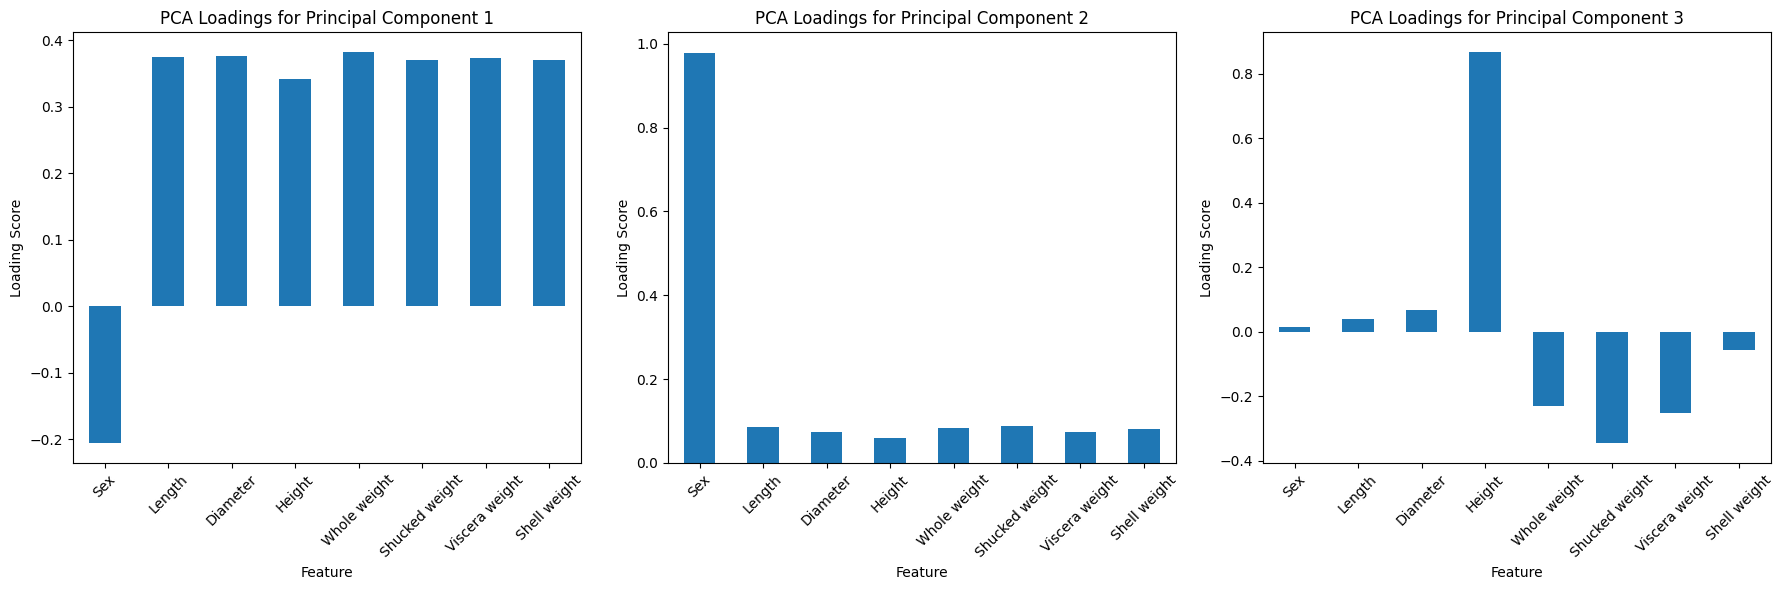

In [11]:
# Perform PCA
pca = PCA(n_components=3)
pca.fit(X_scaled)

# Get the loadings (contributions of each feature to the components)
loadings = pca.components_.T

loadings_df = pd.DataFrame(loadings, columns=[f"PC{i+1}" for i in range(loadings.shape[1])], index=X.columns)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot each PCA loading as a bar plot in its respective subplot
for i, ax in enumerate(axes):
    loadings_df[f"PC{i+1}"].plot(kind="bar", ax=ax)
    ax.set_title(f"PCA Loadings for Principal Component {i+1}")
    ax.set_ylabel("Loading Score")
    ax.set_xlabel("Feature")
    ax.tick_params(axis="x", rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()

plt.show()


Principal Component Analysis (PCA) loadings indicate the contribution of each feature (or variable) to the principal components (PCs). Each principal component represents a linear combination of the original features, and the loadings show how much each feature contributes to that particular component.

- **PC1 (Principal Component 1)**: Most features, like `Length`, `Diameter`, `Whole weight`, etc., contribute similarly to this component, except `Sex`, which has a slightly negative loading. This suggests that most of the features are strongly aligned along this principal component, capturing a large portion of the variance in the data.
- **PC2 (Principal Component 2)**: `Sex` has a dominant positive loading, meaning it largely explains the variance in this component, while other features like `Length` and `Diameter` have small positive loadings.
- **PC3 (Principal Component 3)**: `Height` has a strong positive loading, while `Whole weight`, `Shucked weight`, and `Viscera weight` contribute negatively, indicating that these features play an important role in explaining the variance captured by PC3.

### Purpose of PCA Loadings:
PCA loadings help identify which features are most influential in each principal component, thereby providing insight into how the original features relate to the newly created principal components. In this analysis, `Sex`, `Height`, and weights seem to contribute significantly to the variance in different components, offering a way to reduce dimensionality while maintaining the most important features.